In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as pypatch
import time
%matplotlib inline

cos, sin = np.cos, np.sin
twopi = np.pi*2.0

In [2]:
import time

def time_usage(func):
    def wrapper(*args, **kwargs):
        beg_ts = time.time()
        retval = func(*args, **kwargs)
        end_ts = time.time() 
        print("elapsed time: %f" % (end_ts - beg_ts))
        return retval
    return wrapper

In [3]:
def plotLine(x1,y1,x2,y2,c='b',ax=None):
    if ax: # given axis handle
        ax.plot([x1, x2], [y1, y2], color=c, linestyle='-', linewidth=0.4);
    else:
        plt.gca().plot([x1, x2], [y1, y2], color=c, linestyle='-', linewidth=0.4);

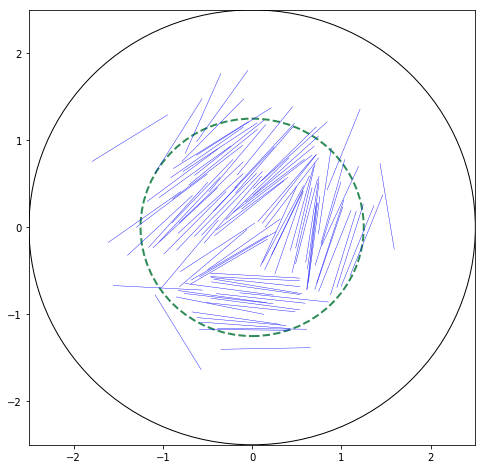

In [6]:
# To view a single unprocessed snap
f = plt.figure(frameon=False);
plt.xticks([]);
plt.yticks([]);
plt.gcf().set_size_inches(8,8);

imgnames = []
bSave = 0
holefactor = 0.
source_dir = "/home/walterms/project/walterms/circ_mcmd/output/defects/"
# imgnames = os.listdir(source_dir)
# tmp = []
# for im in imgnames:
#     if not im.endswith("log") and im.endswith("0.5"):
#         tmp.append(im)
# imgnames = tmp

imgnames = ["minushalf"]

imgdir = "/home/walterms/project/walterms/mcmd/imgs/"
fRot = 0
if imgnames[0].startswith("U"):
    fRot = 2
halfL = 1.0/2

iSnap = -1

for imgname in imgnames:
    f.clf();

    # Count num blocks
    Nblock = 0
# #     iSnap = -1
    dfile = open(source_dir+imgname, "r")
    for line in dfile.readlines():
        if line == "\n": Nblock+=1
    dfile.seek(0)
    if iSnap == -1: iSnap = Nblock-1


    if not (dfile.readline()[0].isalpha()): dfile.seek(0)
    cntSnap = 0
    for line in dfile.readlines():
        if cntSnap == iSnap:
            if line == "\n" or line.startswith("label"): break
            l = [float(x) for x in line.split()]
            x,y,th = l[2],l[3],l[4]
            # Note th=0 is along the y-axis
            x1 = x - halfL*sin(th)
            y1 = y + halfL*cos(th)
            x2 = x + halfL*sin(th)
            y2 = y - halfL*cos(th)

            # Rotations
            th_ = fRot*np.pi*0.5
            x_ = cos(th_)*x - sin(th_)*y
            y_ = sin(th_)*x + cos(th_)*y
            x1_ = cos(th_)*x1 - sin(th_)*y1
            y1_ = sin(th_)*x1 + cos(th_)*y1
            x2_ = cos(th_)*x2 - sin(th_)*y2
            y2_ = sin(th_)*x2 + cos(th_)*y2                

            plotLine(x1_,y1_,x2_,y2_, c="b");
            # T: c=(0,0.6,0.9)
            # X: c=(0,0.8,0.9)
            # D: c=(0.5,0.5,1.0)
            # U: c=(0.5,0.8,1.0)
            # colorpick from jeff: #c2dbf1ff

        else: 
            if line == "\n": cntSnap+=1
    # For circles
    dfile.seek(0)
    ln = dfile.readline().split("|")
    edge = 0.
    holerad = 0.
    for s in ln:
        if "boxEdge" in s:
            edge = float(s.split()[1])
            
        if "defect_radius" in s:
            holerad = float(s.split()[1])
    radius = edge/2.
#     boundary = plt.Rectangle((-radius,-radius),edge,edge,color='k',fill=False,zorder=2);
    boundary = plt.Circle((0, 0), radius, color='k', fill=False);
    innercirc = plt.Circle((0, 0), holerad, color='seagreen', linestyle="--", fill=False, linewidth=2.0);
    dfile.close()
    plt.gca().add_artist(boundary);
    plt.gca().add_artist(innercirc);
#     plt.gca().axis('off');

    # For adding winding numbers
    wcol = "dodgerblue" # dodgerblue, seagreen, gold
    wx, wy = (-radius*0.72,radius*0.7), (-radius*0.7,-radius*0.7) # For U
#     wx, wy = (-radius*0.65,radius*0.72), (-radius*0.75,-radius*0.62) # For D
#     wx, wy = (-radius*0.05,radius*0.73), (radius*0.,radius*0.73) # For T
#     wx, wy = [radius*0.], [radius*0.] # For X
#     plt.scatter(wx,wy,s=1600,edgecolor='k',facecolor=wcol,zorder=3)

    dr = radius*0.
    plt.axis([-radius-dr,radius+dr,-radius-dr,radius+dr])
#     plt.gca().set_aspect("equal")
#     plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#                 hspace = 0.1, wspace = 0.1)
#     plt.margins(0.01,0.01)
#     plt.gca().xaxis.set_major_locator(plt.NullLocator())
#     plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.gca().set_axis_off()
    
    if bSave:
        savename = imgdir+imgname+"_"+str(iSnap)+".eps"
        print "Saving file ",savename
        f.savefig(savename,pad_inches=0)
#         f.savefig(savename,pad_inches=0,bbox_inches='tight')

In [21]:
## Analyze movement of rods
fname = "/home/walterms/project/walterms/mcmd/output/T"

dfile = open(fname,"r")
# Find edge/radius
dfile.seek(0)
ln = dfile.readline().split("|")
edge = 0.
cellNx = 0
bUncrossIncl = 0
for s in ln:
    if "cellNx" in s:
        cellNx = int(s.split()[1])
    if "boxEdge" in s:
        edge = float(s.split()[1])
    if "printUncross" in s:
        bUncrossIncl = int(s.split()[1])
radius = edge/2.

deficit = -2
Nbl = deficit # Subtract for init img
    
for line in dfile.readlines():
    if line == "\n":
        Nbl+=1
dfile.seek(0)

rodtrack = {}
cellHaveDict = {}
for i in range(cellNx**2):
    cellHaveDict.update({i:0})

dfile.readline()
nbl = deficit
rids = []
for line in dfile.readlines():
    if line=="\n": 
        if nbl < 1:
            nbl+=1
            continue
        if nbl == 0: break
    if nbl == 0:
        spt = line.split()
        rid = int(spt[0])
        cell = int(spt[1])
        if cellHaveDict[cell]: continue
        else: 
            cellHaveDict[cell] = 1
            rids.append(rid)
        rod = [float(d) for d in spt[2:5]]
        rodtrack.update({rid:np.zeros(shape=(3,Nbl))})

print "initialized dicts"
print len(rodtrack)," rods in rodtrack"
print Nbl, " blocks"

dfile.seek(0)
dfile.readline()
nbl = deficit
for line in dfile.readlines():
    if nbl < 0:
        if line == "\n":
            nbl+=1
        continue

    if line == "\n":
        if nbl%1000==0:
            print nbl
        nbl+=1
        continue
    spt = line.split()
    rid = int(spt[0])
    if rid in rids:
        rod = [float(d) for d in spt[2:5]]
        rodtrack[rid][0,nbl] = rod[0]
        rodtrack[rid][1,nbl] = rod[1]
        rodtrack[rid][2,nbl] = rod[2]
        
dfile.close()
print "Done"

initialized dicts
36  rods in rodtrack
1999  blocks
0


KeyboardInterrupt: 

In [ ]:
f = plt.figure();
# plt.xticks([]);
# plt.yticks([]);

for ri in range(10):
    rid = rids[ri]
    t = [tt for tt in range(Nbl)]
    xs = [v for v in rodtrack[rid][0]]
    ys = [v for v in rodtrack[rid][1]]

    x1 = xs[0]
    y1 = ys[0]
    for i in range(1,Nbl):
        x2 = xs[i]
        y2 = ys[i]
        plotLine(x1,y1,x2,y2);
        x1 = x2
        y1 = y2
    

# Draw path as series of rods
radius = edge/2.
# Plot box
# plotLine(-radius, -radius, radius,-radius,c="k")
# plotLine(radius, -radius, radius,radius,c="k")
# plotLine(radius, radius, -radius,radius,c="k")
# plotLine(-radius, radius, -radius,-radius,c="k")

# boundary = plt.Rectangle((-radius,-radius),edge,edge,color='k',fill=False);
boundary = plt.Circle((0, 0), radius, color='k', fill=False);
# plt.gca().add_artist(boundary);
# plt.gca().axis('off');
plt.gcf().set_size_inches(8,8);


In [8]:
# Calculate dxs
deltas = np.zeros(shape=(4,Nbl-1))
last = rodtrack[0][:,0]
i = 0 
for i in range(Nbl-1):
    deltas[0,i] = rodtrack[0][0,i+1] - last[0]
    deltas[1,i] = rodtrack[0][1,i+1] - last[1]
    deltas[2,i] = rodtrack[0][2,i+1] - last[2]
    deltas[3,i] = np.sqrt(deltas[0,i]*deltas[0,i] + deltas[1,i]*deltas[1,i])
    last = rodtrack[0][:,i+1]

In [ ]:
plt.hist(deltas[1,:],bins=20)

In [9]:
a = [0.,1.]
b = [0.5,0.5]
c = [aa+bb for aa,bb in zip(a,b)]
print c

[0.5, 1.5]


In [ ]:
tmp()

In [9]:
es = ["15.00","16.00","17.00"]
ns = [str(i) for i in [45,50,60,70]]
ths = ["0.00","0.05","0.10","0.15"]

# Types with their snap idx
types = {"init": 0, "uncrossed": 1, "processed": -1}
category = "spiral"
print "Category is "+category

f = plt.figure();
plt.xticks([]);
plt.yticks([]);


for typ in types:
    print "Working on "+typ+"..."
    for e in es:
        print e
        for n in ns:
            for th in ths:
                # To view a single unprocessed snap
                imgname = category+"_e"+e+"_n"+n+"_th"+th
                source_dir = "/home/walterms/project/walterms/circ_mcmd/output/"
                savedir = "/home/walterms/project/walterms/circ_mcmd/imgs/"+category+"/"+typ+"/"
                iSnap = types[typ]
                tag = typ
                halfL = 1.0/2

                # Count num blocks
                Nblock = 0
                dfile = open(source_dir+imgname, "r")
                for line in dfile.readlines():
                    if line == "\n": Nblock+=1
                dfile.seek(0)
                if iSnap == -1: iSnap = Nblock-1


                if not (dfile.readline()[0].isalpha()): dfile.seek(0)
                cntSnap = 0
                for line in dfile.readlines():
                    if cntSnap == iSnap:
                        if line == "\n" or line.startswith("label"): break
                        l = [float(x) for x in line.split()]
                        x,y,th = l[2],l[3],l[4]
                        # Note th=0 is along the y-axis
                        x1 = x - halfL*sin(th)
                        y1 = y + halfL*cos(th)
                        x2 = x + halfL*sin(th)
                        y2 = y - halfL*cos(th)

                        plotLine(x1,y1,x2,y2);

                    else: 
                        if line == "\n": cntSnap+=1
                # For circles
                dfile.seek(0)
                ln = dfile.readline().split("|")
                edge = 0.
                for s in ln:
                    if "boxEdge" in s:
                        edge = float(s.split()[1])
                radius = edge/2.
                # boundary = plt.Rectangle((-radius,-radius),edge,edge,color='k',fill=False);
                boundary = plt.Circle((0, 0), radius, color='k', fill=False);
                dfile.close()
                plt.gca().add_artist(boundary);
                plt.gca().axis('off');
                plt.gcf().set_size_inches(8,8);
        #         plt.show()

        #         f = plt.gcf()
                f.savefig(savedir+imgname+".png")
                f.clf();
print "Done"

Category is spiral
Working on uncrossed...
15.00
16.00
17.00
Working on init...
15.00
16.00
17.00
Working on processed...
15.00
16.00
17.00
Done


In [ ]:
# For reading processed snaps
run1 = "xjam"
run2 = "mixed"
source_dir = "/home/walterms/project/walterms/mcmd/nn/fnn/data/mixed/train/"
dfile1 = open(source_dir+run1, "r")
dfile2 = open(source_dir+run2, "r")
Snaps = np.arange(2000,4000,4)
nsnap = len(Snaps)

d1, d2 = [], []
frot1, frot2 = 1, 0
th1s = []
th2s = []

cntSnap = 0
for line in dfile1.readlines():
    if line == "\n": 
        cntSnap+=1
        continue
    if line.startswith("label"): 
        continue
    if cntSnap in Snaps:
        l = [float(x) for x in line.split()]
        th_ = frot1*0.25
        th = l[2]+th_
        if th>1.: th-=1.
        th1s.append(th)
dfile1.close()

cntSnap = 0
for line in dfile2.readlines():
    if line == "\n": 
        cntSnap+=1
        continue
    if line.startswith("label"): 
        continue
    if cntSnap in Snaps:
        if line == "\n": cntSnap+=1
        l = [float(x) for x in line.split()]
        th_ = frot2*0.25
        th = l[2]+th_
        if th>1.: th-=1.
        th2s.append(th)
dfile2.close()

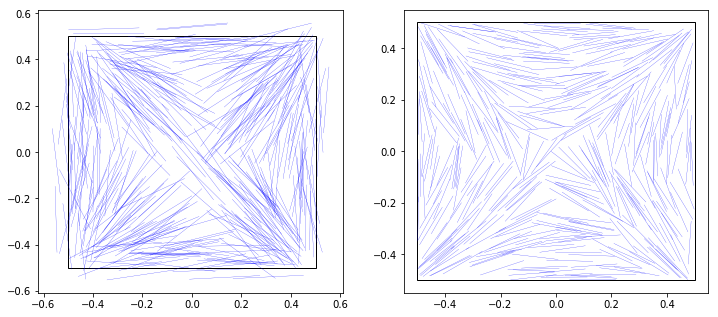

In [19]:
# For reading two processed files:
# A given file run2 and its fedforward result run1
# Careful with feedskip, seqlen, batchsize etc.
# To compare same iSnaps, just set seq_len to 0

run1 = "/home/walterms/project/walterms/mcmd/nn/data/train/xjam_0.1"
run2 = "/scratch/walterms/mcmd/output/xmelt/processed/xmelt_test"
dfile1 = open(run1, "r")
dfile2 = open(run2, "r")

# xmelt has boxlength of 6 -> rod length 1/6
edge1 = 3.5
edge2 = 6.0
halfL1 = 0.5*(1/edge1)
halfL2 = 0.5*(1/edge2)

iSnap_1 = 10

feedskip = 1
seq_len = 1

# Find appropriate snap in OG file
iSnap_2 = iSnap_1 + feedskip*seq_len

img1, img2 = [], []

cntSnap = 0
for line in dfile1.readlines():
    if line.startswith("label"): continue
    if cntSnap == iSnap_1:
        if line == "\n": break
        l = [float(x) for x in line.split()]
        img1.append([l[0],l[1],l[2]])
    else: 
        if line == "\n": cntSnap+=1
        else: continue
dfile1.close()

cntSnap = 0
for line in dfile2.readlines():
    if line.startswith("label"): continue
    if cntSnap == iSnap_2:
        if line == "\n": break
        l = [float(x) for x in line.split()]
        img2.append([l[0],l[1],l[2]])
    else: 
        if line == "\n": cntSnap+=1
        else: continue
dfile2.close()

f,ax = plt.subplots(1,2,figsize=(12,5.2))
# plt.xticks([])
# plt.yticks([])


for rod in img1:
    x,y = rod[0],rod[1]
    th = rod[2]
    th *= twopi
    x1 = x - halfL1*sin(th)
    y1 = y + halfL1*cos(th)
    x2 = x + halfL1*sin(th)
    y2 = y - halfL1*cos(th)

    plotLine(x1,y1,x2,y2,ax=ax[0])

for rod in img2:
    x,y = rod[0],rod[1]
    th = rod[2]
    th *= twopi
    x1 = x - halfL2*sin(th)
    y1 = y + halfL2*cos(th)
    x2 = x + halfL2*sin(th)
    y2 = y - halfL2*cos(th)

    plotLine(x1,y1,x2,y2,ax=ax[1])

# For circles
radius = 0.5
boundary1 = pypatch.Rectangle((-radius,-radius),1.,1.,color='k',fill=False)
boundary2 = pypatch.Rectangle((-radius,-radius),1.,1.,color='k',fill=False)
ax[0].add_patch(boundary1)
ax[1].add_patch(boundary2)
# ax[0].axis('off')
# ax[1].axis('off')
ax[0].figure.canvas.draw()
ax[1].figure.canvas.draw()


In [ ]:
f,ax = plt.subplots(2,2,figsize=(12,8.2))
xs1,ys1,th1,xs2,ys2,th2=[],[],[],[],[],[]
for i in range(400):
    xs1.append(d1[i][1])
    ys1.append(d1[i][2])
    th1.append(d1[i][0])
    xs2.append(d2[i][1])
    ys2.append(d2[i][2])
    th2.append(d2[i][0])
ax[0,0].hist([xs1,xs2], color=['k','c'])
ax[0,1].hist([ys1,ys2], color=['k','r'])
ax[1,0].hist([th1,th2], color=['k','m'])

In [ ]:
# To view a processed theta-avg image compared with its rodplot
run = "bigbox1"
run_th = run+"_th"
source_dir = "/home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/"
iSnap = 1
cntSnap = 0

# for rodplot
# width = 15.
# halfL = 3.0/2.*1./width
# jams
width = 3.5
halfL = 1.0/2.*1./width

f,ax = plt.subplots(1,2)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

# Theta plot
dfile_th = open(source_dir+run_th, "r")
ntheta = len(dfile_th.readline().split())
gridx = int(np.sqrt(ntheta))
gridy = gridx
dfile_th.seek(0)
dx,dy = 1./gridx, 1./gridy
for line in dfile_th.readlines():
    if cntSnap > iSnap: break
    if cntSnap == iSnap:
        l = [float(x) for x in line.split()]
        for ix in range(gridx):
            for iy in range(gridy):
                i = int(gridx*ix + iy)
                th = l[i]
                if th == 0.: continue
                x,y = dx*ix+dx/2., dy*iy+dy/2.
                # Note th=0 is along the y-axis
                x1 = x - (dx/2.)*sin(th*twopi) 
                y1 = y + (dy/2.)*cos(th*twopi)
                x2 = x + (dx/2.)*sin(th*twopi)
                y2 = y - (dy/2.)*cos(th*twopi)
        
                plotLine(x1,y1,x2,y2,ax=ax[1])
        cntSnap += 1
    else: 
        if line == "\n": cntSnap+=1
dfile_th.close()

# Paint gridlines
for ix in range(gridx+1):
    x1 = dx*ix
    y1 = 0.
    y2 = 1.
    x2 = x1
    plotLine(x1,y1,x2,y2,ax=ax[0],c="dimgrey")
    plotLine(x1,y1,x2,y2,ax=ax[1],c="dimgrey")
for iy in range(gridy+1):
    x1 = 0.
    y1 = dy*iy
    y2 = y1
    x2 = 1.
    plotLine(x1,y1,x2,y2,ax=ax[0],c="dimgrey")
    plotLine(x1,y1,x2,y2,ax=ax[1],c="dimgrey")

# Rodplot
dfile = open(source_dir+run, "r")
if not (dfile.readline()[0].isalpha()): dfile.seek(0)
cntSnap = 0
for line in dfile.readlines():
    if cntSnap == iSnap:
        if line == "\n" or line.startswith("label"): break
        l = [float(x) for x in line.split()]
        x,y,th = l[0],l[1],l[2]
        xi = int(x/dx)
        yi = int(y/dy)
        i = gridx*xi + yi
        # Note th=0 is along the y-axis
        x1 = x - halfL*sin(th*twopi) 
        y1 = y + halfL*cos(th*twopi)
        x2 = x + halfL*sin(th*twopi)
        y2 = y - halfL*cos(th*twopi)
        
        ax[0].plot(x,y,'r.')
        plotLine(x1,y1,x2,y2,ax=ax[0])
    else: 
        if line == "\n": cntSnap+=1
dfile.close()

plt.gcf().set_size_inches(12.5,6)

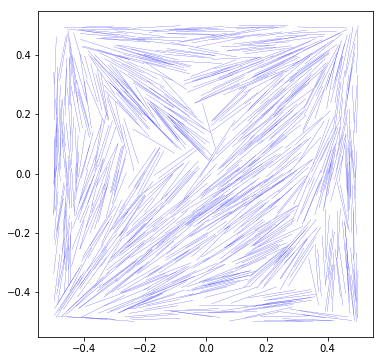

In [13]:
# To view a single processed snap
run = "T"
source_dir = "/home/walterms/project/walterms/mcmd/nn/data/train/"
iSnap = 8
fRot = 0
width = 6.23
halfL = 1.0/2.*1./width

f = plt.figure()
# a = plt.Axes(f, [0., 0., 1., 1.])
# a.set_axis_off()
# f.add_axes(a)
# plt.xlim(-w/2,w/2)
# plt.ylim(-h/2,h/2)
# plt.xticks([])
# plt.yticks([])


dfile = open(source_dir+run, "r")
if not (dfile.readline()[0].isalpha()): dfile.seek(0)
cntSnap = 0
for line in dfile.readlines():
    if cntSnap == iSnap:
        if line == "\n" or line.startswith("label"): break
        l = [float(x) for x in line.split()]
        x,y,th = l[0],l[1],l[2]
        # Note th=0 is along the y-axis
        x1 = x - halfL*sin(th*twopi) 
        y1 = y + halfL*cos(th*twopi)
        x2 = x + halfL*sin(th*twopi)
        y2 = y - halfL*cos(th*twopi)
        
        # Rotations
        th_ = fRot*np.pi*0.5
        x_ = cos(th_)*x - sin(th_)*y
        y_ = sin(th_)*x + cos(th_)*y
        x1_ = cos(th_)*x1 - sin(th_)*y1
        y1_ = sin(th_)*x1 + cos(th_)*y1
        x2_ = cos(th_)*x2 - sin(th_)*y2
        y2_ = sin(th_)*x2 + cos(th_)*y2

        plotLine(x1_,y1_,x2_,y2_)
    else: 
        if line == "\n": cntSnap+=1
dfile.close()
plt.gcf().set_size_inches(6,6)

In [ ]:
diag1 = ['15.00', '15.48', '15.74', '16.30', '16.92', '17.26']
diag2 = ['15.12', '15.24', '16.01', '16.60']

In [ ]:
def Lambda(thetas):
    s, c, = 0.,0.
    for t in thetas:
        s += sin(2.*t)
        c += cos(2.*t)
    s /= float(len(thetas))
    c /= float(len(thetas))
    return np.sqrt(s*s + c*c)

In [ ]:
# For following a rod
run = "djam2"
source_dir = "/home/walterms/project/walterms/mcmd/djam/"

xs,ys,ths=[],[],[]
irod = 200
cntSnap = 0
nSnaps = -1

dfile = open(source_dir+run, "r")
if not (dfile.readline()[0].isalpha()): dfile.seek(0)
for line in dfile.readlines():
    if line == "\n": 
        cntSnap+=1
        continue
    l = [float(x) for x in line.split()]
    if int(l[0]) == irod:
        # Record xytheta
        xs.append(l[2])
        ys.append(l[3])
        ths.append(l[4])
    if cntSnap == nSnaps:
        break

dfile.close()
print "Done"

In [ ]:
# To calculate lambda on unprocessed snaps
run = "X_L04_real"
source_dir = "/home/walterms/project/walterms/mcmd/output/"
w = 16.
iSnap = 200
fRot = 0

dfile = open(source_dir+run, "r")
if not (dfile.readline()[0].isalpha()): dfile.seek(0)
cntSnap = 0
thetas = []
lambdas = []
for line in dfile.readlines():
    if cntSnap < iSnap and cntSnap > 1:
        if line == "\n" or line.startswith("label"):
            lambdas.append(Lambda(thetas))
            thetas = []
            cntSnap += 1
            continue
        l = [float(x) for x in line.split()]
        th = l[4]
        
        # Rotations
        th_ = fRot*np.pi*0.5
        th += th_
        if th > 2.*np.pi: th-=2.*np.pi
        thetas.append(th)

    else: 
        if line == "\n": cntSnap+=1
            
print "Done"
dfile.close()

In [ ]:
plt.plot(lambdas)

In [ ]:
# To prep imgs for tfrecords 
# Read in data
edges = []
edgefile = open("../edgelist","r")
for e in edgefile.readlines():
    edges.append(e.strip())

N = 400
L = 3.0
rho_ = [L*L*N/(float(x)*float(x)) for x in edges]

unlabeledfnames = ["edge"+str(x) for x in edges]
print unlabeledfnames

run = "edge15"
source_dir = "/home/walterms/project/walterms/mcmd/output/edgevar/"
imgdir = source_dir+"imgs/"+run+"/"

# Try and make the dir
try:
    os.mkdir(imgdir)
    print "Creating new dir: " + imgdir
except OSError as e:
    print "Dir already exists: " + imgdir
    pass
dfile = open(source_dir+run, "r")

Nbl = 0
for line in dfile.readlines():
    if line == "\n":
        Nbl+=1
dfile.seek(0)
dfile.close()
print "Nbl", Nbl

smin = 0 # Minimum should be 1
smax = Nbl
print "Snaplist ranges " + str(smin) + " to " + str(smax)
snaplist = range(smin,smax) # Note minimum should be 1

In [ ]:
genImgs()

In [ ]:
@time_usage
def genImgs():
    print "Processing images " + str(smin) + " to " + str(smax) + " of run " +run+ " into"
    print imgdir
    nPerTar = 500
    print str(nPerTar) + " imgs per tar file"
    
    h = w
    f = plt.figure(figsize=(128./86,128./86), dpi=86, frameon=False)
    a = plt.Axes(f, [0., 0., 1., 1.])
    a.set_axis_off()
    f.add_axes(a)
    plt.xlim(-w/2,w/2)
    plt.ylim(-h/2,h/2)
    plt.xticks([])
    plt.yticks([])

    # reads a line, if it is not alphabetic, go back to top
    dfile = open(source_dir+run, "r")
    if not (dfile.readline()[0].isalpha()): dfile.seek(0)
    bSave = True
    cntSnap = 0
    tarQ = 0 # counts how many for current tar
    fRot = 0
    for line in dfile.readlines():
        if cntSnap in snaplist:
            if line == "\n":
                f.savefig(imgdir+str(cntSnap)+".png");
                if cntSnap!=snaplist[-1]:
                    del plt.gca().lines[:]
                else:
                    nPerTar = (cntSnap+1)%nPerTar
                    tarQ = nPerTar-1
#                 if (cntSnap-smin)%((smax-smin)/100)==0: print cntSnap
                cntSnap+=1
                tarQ+=1
                fRot = (fRot+1)%4
                if tarQ == nPerTar:
                    first = cntSnap - nPerTar
                    last = cntSnap - 1
                    fname = str(first)+"_"+str(last)+".tar.gz"
                    print "Writing " + fname
                    with tarfile.open(imgdir+fname,'w:gz') as tarf:
                        for i in range(first,last+1):
                            tarf.add(imgdir+str(i)+".png", arcname=str(i)+".png")
                            os.remove(imgdir+str(i)+".png")
                    tarQ = 0
                continue
            l = [float(x) for x in line.split()]
            th_ = fRot*np.pi*0.5
            x1 = np.cos(th_)*l[5] - np.sin(th_)*l[6]
            y1 = np.sin(th_)*l[5] + np.cos(th_)*l[6]
            x2 = np.cos(th_)*l[7] - np.sin(th_)*l[8]
            y2 = np.sin(th_)*l[7] + np.cos(th_)*l[8]
            plotLine(x1,y1,x2,y2)
#             plotLine(l[5],l[6],l[7],l[8])
        else: 
            if line == "\n": cntSnap+=1
            else: continue
    dfile.close()
    f = plt.gcf()
    # plt.gcf().set_size_inches(8,8)

In [ ]:
f.savefig(source_dir+run+str(w)+".png");